In [ ]:
# Required Libraries
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# Define paths for loading and saving images
input_dir = r"C:\Users\dave-\OneDrive - ZHAW\HS24\MoIm\SW7_Projekt\Images\test_images"
output_dir = r"C:\Users\dave-\OneDrive - ZHAW\HS24\MoIm\SW7_Projekt\Images\output_masks"
os.makedirs(output_dir, exist_ok=True)

# Load SAM Model
model_type = "vit_h"  # Model type can be "vit_h", "vit_l", or "vit_b"
sam = sam_model_registry[model_type](checkpoint="./sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

# Processing TIF Images in Batch
def process_images(input_dir, output_dir):
    for file_name in os.listdir(input_dir):
        if file_name.endswith(".tif"):
            file_path = os.path.join(input_dir, file_name)
            image = Image.open(file_path)
            image_np = np.array(image)
            
            # Convert from uint16 to uint8 by normalizing
            image_np = (image_np / image_np.max() * 255).astype(np.uint8)
            
            # Convert grayscale to RGB by stacking along the third dimension
            image_rgb = np.stack([image_np] * 3, axis=-1)

            # Use SAM to generate mask for the zebrafish with a sample point
            predictor.set_image(image_rgb)

            # Define a point on the zebrafish (adjust coordinates as needed)
            input_point = np.array([[image_rgb.shape[1] // 2, image_rgb.shape[0] // 2]])  # Midpoint of the image
            input_label = np.array([1])  # Label '1' for foreground

            # Predict mask based on the input point
            masks, scores, _ = predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                multimask_output=False
            )
            mask = masks[0]  # Get the first mask

            # Save mask as TIF
            output_path = os.path.join(output_dir, f"mask_{file_name}")
            Image.fromarray((mask * 255).astype(np.uint8)).save(output_path)

            # Display
            plt.imshow(mask, cmap='gray')
            plt.title(f"Mask for {file_name}")
            plt.axis('off')
            plt.show()

# Run the function on the directory
process_images(input_dir, output_dir)

In [ ]:
import os
import re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# Define paths for loading and saving images
input_dir = r"C:\Users\dave-\OneDrive - ZHAW\HS24\MoIm\SW7_Projekt\Images\test_images"
output_dir = r"C:\Users\dave-\OneDrive - ZHAW\HS24\MoIm\SW7_Projekt\Images\output_masks"
os.makedirs(output_dir, exist_ok=True)

# Load SAM Model
model_type = "vit_h"  # Model type can be "vit_h", "vit_l", or "vit_b"
sam = sam_model_registry[model_type](checkpoint="./sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

# Function to extract the unique identifier (first two parts and last three digits)
def get_identifier(filename):
    match = re.match(r"^([A-H]\d+_\d+).*_(\d{3})\.tif$", filename)
    if match:
        return f"{match.group(1)}_{match.group(2)}"
    return None

# Processing TIF Images in Batch
def process_images(input_dir, output_dir):
    # Collect Phase Contrast and GFP files based on unique identifier
    phase_contrast_files = {}
    gfp_files = {}
    
    for file_name in os.listdir(input_dir):
        if file_name.endswith(".tif"):
            identifier = get_identifier(file_name)
            if identifier:
                if "Phase Contrast" in file_name:
                    phase_contrast_files[identifier] = file_name
                elif "GFP" in file_name:
                    gfp_files[identifier] = file_name

    # Process each pair of Phase Contrast and GFP files
    for identifier, phase_file in phase_contrast_files.items():
        if identifier in gfp_files:
            # Load Phase Contrast and GFP images
            phase_path = os.path.join(input_dir, phase_file)
            gfp_path = os.path.join(input_dir, gfp_files[identifier])
            
            # Generate mask from the Phase Contrast image
            phase_image = Image.open(phase_path)
            phase_np = np.array(phase_image)
            
            # Convert from uint16 to uint8 by normalizing
            phase_np = (phase_np / phase_np.max() * 255).astype(np.uint8)
            
            # Convert grayscale to RGB by stacking along the third dimension
            phase_rgb = np.stack([phase_np] * 3, axis=-1)
            
            # Use SAM to generate mask for the zebrafish
            predictor.set_image(phase_rgb)

            # Define a point on the zebrafish (adjust coordinates as needed)
            input_point = np.array([[phase_rgb.shape[1] // 2, phase_rgb.shape[0] // 2]])  # Midpoint of the image
            input_label = np.array([1])  # Label '1' for foreground

            # Predict mask based on the input point
            masks, scores, _ = predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                multimask_output=False
            )
            mask = masks[0]  # Get the first mask
            
            # Apply mask to the GFP image
            gfp_image = Image.open(gfp_path)
            gfp_np = np.array(gfp_image)
            gfp_masked = gfp_np * mask  # Apply the mask to the GFP image

            # Save the masked GFP image
            output_path = os.path.join(output_dir, f"masked_{gfp_files[identifier]}")
            Image.fromarray(gfp_masked).save(output_path)

            # Display
            plt.imshow(gfp_masked, cmap='gray')
            plt.title(f"Masked GFP for {gfp_files[identifier]}")
            plt.axis('off')
            plt.show()

# Run the function on the directory
process_images(input_dir, output_dir)


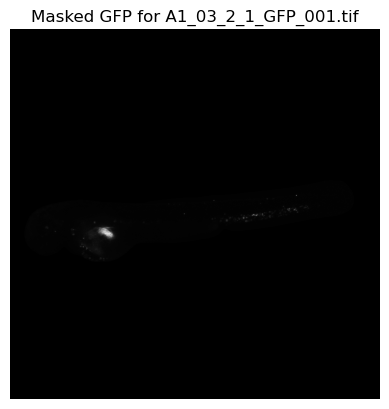

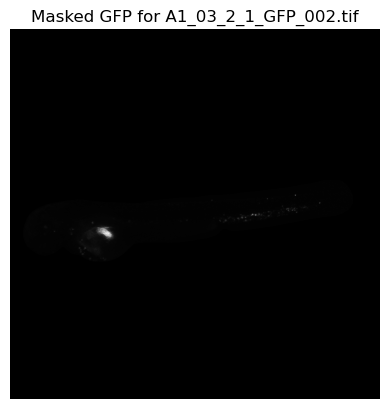

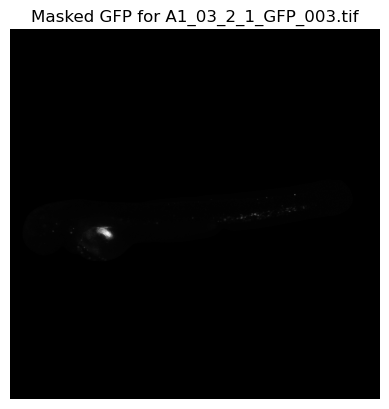

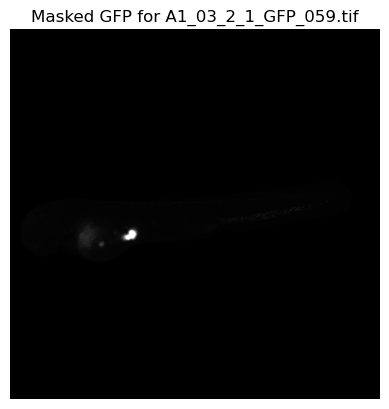

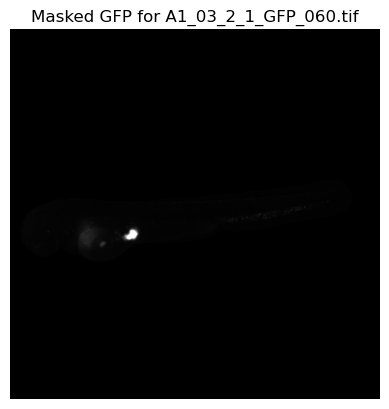

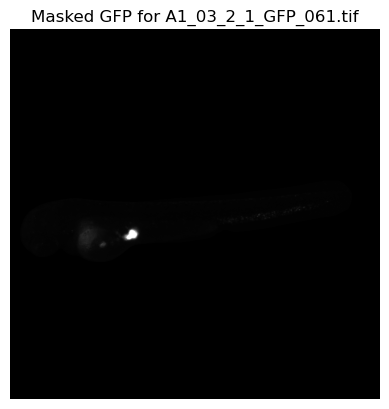

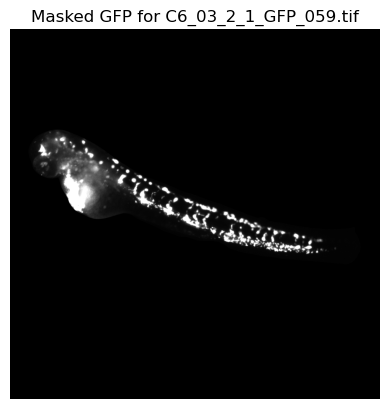

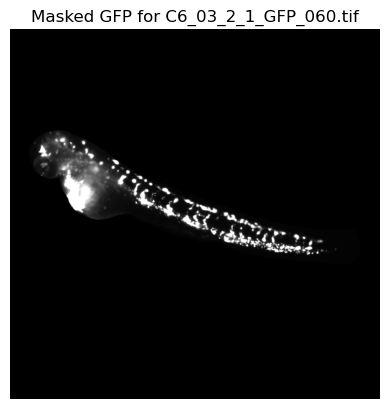

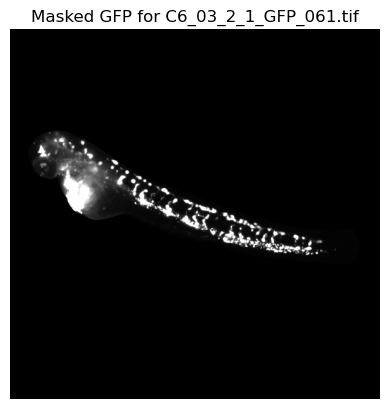

In [17]:
import os
import re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# Define paths for loading and saving images
input_dir = r"C:\Users\dave-\OneDrive - ZHAW\HS24\MoIm\SW7_Projekt\Images\test_images"
output_dir = r"C:\Users\dave-\OneDrive - ZHAW\HS24\MoIm\SW7_Projekt\Images\output_masks"
phase_mask_dir = os.path.join(output_dir, "masks")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(phase_mask_dir, exist_ok=True)

# Load SAM Model
model_type = "vit_h"  # Model type can be "vit_h", "vit_l", or "vit_b"
sam = sam_model_registry[model_type](checkpoint="./sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

# Function to extract the unique identifier (first two parts and last three digits)
def get_identifier(filename):
    match = re.match(r"^([A-H]\d+_\d+).*_(\d{3})\.tif$", filename)
    if match:
        return f"{match.group(1)}_{match.group(2)}"
    return None

# Processing TIF Images in Batch
def process_images(input_dir, output_dir, phase_mask_dir):
    # Collect Phase Contrast and GFP files based on unique identifier
    phase_contrast_files = {}
    gfp_files = {}
    
    for file_name in os.listdir(input_dir):
        if file_name.endswith(".tif"):
            identifier = get_identifier(file_name)
            if identifier:
                if "Phase Contrast" in file_name:
                    phase_contrast_files[identifier] = file_name
                elif "GFP" in file_name:
                    gfp_files[identifier] = file_name

    # Process each pair of Phase Contrast and GFP files
    for identifier, phase_file in phase_contrast_files.items():
        if identifier in gfp_files:
            # Load Phase Contrast and GFP images
            phase_path = os.path.join(input_dir, phase_file)
            gfp_path = os.path.join(input_dir, gfp_files[identifier])
            
            # Generate mask from the Phase Contrast image
            phase_image = Image.open(phase_path)
            phase_np = np.array(phase_image)
            
            # Convert from uint16 to uint8 by normalizing
            phase_np = (phase_np / phase_np.max() * 255).astype(np.uint8)
            
            # Convert grayscale to RGB by stacking along the third dimension
            phase_rgb = np.stack([phase_np] * 3, axis=-1)
            
            # Use SAM to generate mask for the zebrafish
            predictor.set_image(phase_rgb)

            # Define a point on the zebrafish (adjust coordinates as needed)
            input_point = np.array([[phase_rgb.shape[1] // 2, phase_rgb.shape[0] // 2]])  # Midpoint of the image
            input_label = np.array([1])  # Label '1' for foreground

            # Predict mask based on the input point
            masks, scores, _ = predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                multimask_output=False
            )
            mask = masks[0]  # Get the first mask
            
            # Save the mask from the Phase Contrast image in the phase_masks subfolder
            mask_output_path = os.path.join(phase_mask_dir, f"mask_{phase_file}")
            Image.fromarray((mask * 255).astype(np.uint8)).save(mask_output_path)

            # Apply mask to the GFP image
            gfp_image = Image.open(gfp_path)
            gfp_np = np.array(gfp_image)
            gfp_masked = gfp_np * mask  # Apply the mask to the GFP image

            # Save the masked GFP image
            output_path = os.path.join(output_dir, f"masked_{gfp_files[identifier]}")
            Image.fromarray(gfp_masked).save(output_path)

            # Display
            plt.imshow(gfp_masked, cmap='gray')
            plt.title(f"Masked GFP for {gfp_files[identifier]}")
            plt.axis('off')
            plt.show()

# Run the function on the directory
process_images(input_dir, output_dir, phase_mask_dir)
